In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii as ascii
import astropy.time as time
import astropy.units as units
import astropy.coordinates as coordinates
import platedesign.observatory
import datetime
import astroplan
import bag.night as night
import PyAstronomy.pyasl as pyasl

In [2]:
apo_schedule = night.Schedule(observer=night.apo_observer())

In [3]:
rdr = ascii.get_reader(Reader=ascii.Basic)
schedule = rdr.read('Sch_base.Aug16.RM_ELG.txt')

In [4]:
# Start with Sep 5 2017
jdstart = 2400000.5 + 58000
# jds = np.arange(365, dtype=np.int32) + jdstart

In [5]:
ischedule = np.where((schedule['MJD'] > jdstart) &
                     (schedule['Eng'] == 0))[0]
jds = schedule['MJD'][ischedule] + 0.5

In [6]:
dates = time.Time(jds, format='jd')

In [7]:
apo = platedesign.observatory.Observatory('APO')
temperature= units.Quantity(10., unit='deg_C')
relative_humidity = 0.5
obswl= units.Quantity(8000., unit='Angstrom')

In [8]:
interval_hours = 15. / 60.
interval_days = interval_hours / 24.

In [9]:
ninterval = 0
exposures = np.zeros(0, dtype=np.float64)
for date in dates:
    apo_schedule.calculate(date.tt.datetime)
    ninterval_tmp = np.int32(np.floor((apo_schedule.time_end - apo_schedule.time_start) / interval_days))
    exposures_tmp = (np.arange(ninterval_tmp) + 0.5) * interval_days + apo_schedule.time_start 
    exposures = np.append(exposures, exposures_tmp)
    ninterval = ninterval + ninterval_tmp
exposures = exposures + 2400000.5

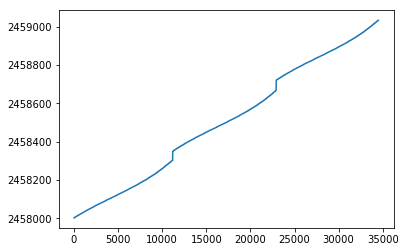

In [10]:
plt.plot(exposures)

In [11]:
moon_ras, moon_decs, dist, geolon, geolat = pyasl.moonpos(exposures)
lsts = 15. * pyasl.ct2lst(exposures, np.zeros(len(exposures)) + apo.location.longitude.value)
moon_has = lsts - moon_ras

In [12]:
moon_alts, moon_azs = pyasl.hadec2altaz(moon_has, moon_decs, np.zeros(len(exposures)) + apo.location.latitude.value)

In [13]:
moon_illuminations = pyasl.moonphase(exposures)

In [14]:
dark = np.zeros(24)
grey = np.zeros(24)
bright = np.zeros(24)
for (lst, moon_alt, moon_illumination) in zip(lsts, moon_alts, moon_illuminations):
    ilst = np.int32(np.floor(lst / 15.))
    if((moon_illumination < 0.35) or
       ((moon_alt < 0.) and (moon_illumination < 0.75))):
        dark[ilst] = dark[ilst] + interval_hours 
    else:
        if((moon_illumination > 0.35) and
           (moon_illumination < 0.45) and
           (moon_alt < 30.)):
            grey[ilst] = grey[ilst] + interval_hours
        else:
            bright[ilst] = bright[ilst] + interval_hours

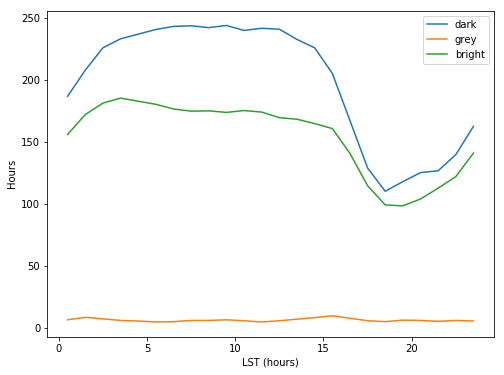

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(24) + 0.5, dark, label='dark')
plt.plot(np.arange(24) + 0.5, grey, label='grey')
plt.plot(np.arange(24) + 0.5, bright, label='bright')
plt.xlabel('LST (hours)')
plt.ylabel('Hours')
plt.legend()

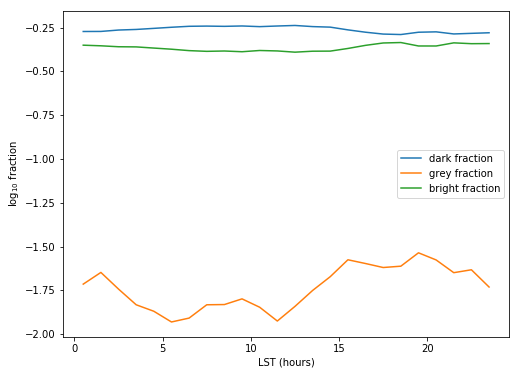

In [16]:
all = dark + grey + bright
plt.figure(figsize=(8, 6))
plt.plot(np.arange(24) + 0.5, np.log10(dark / all), label='dark fraction')
plt.plot(np.arange(24) + 0.5, np.log10(grey / all), label='grey fraction')
plt.plot(np.arange(24) + 0.5, np.log10(bright / all), label='bright fraction')
plt.xlabel('LST (hours)')
plt.ylabel('log$_{10}$ fraction')
plt.legend()

In [17]:
print(dark.sum() / (dark.sum() + bright.sum() + grey.sum()))
print(grey.sum() / (dark.sum() + bright.sum() + grey.sum()))
print(bright.sum() / (dark.sum() + bright.sum() + grey.sum()))

0.552583533776
0.0181702263309
0.429246239893


In [18]:
print(dark.sum())
print(grey.sum())
print(bright.sum())

4767.0
156.75
3703.0


In [19]:
dark = np.zeros(24)
bright = np.zeros(24)
for (lst, moon_alt, moon_illumination) in zip(lsts, moon_alts, moon_illuminations):
    ilst = np.int32(np.floor(lst / 15.))
    if((moon_illumination < 0.35) or
       ((moon_alt < 0.) and (moon_illumination < 0.75))):
        dark[ilst] = dark[ilst] + interval_hours 
    else:
        bright[ilst] = bright[ilst] + interval_hours

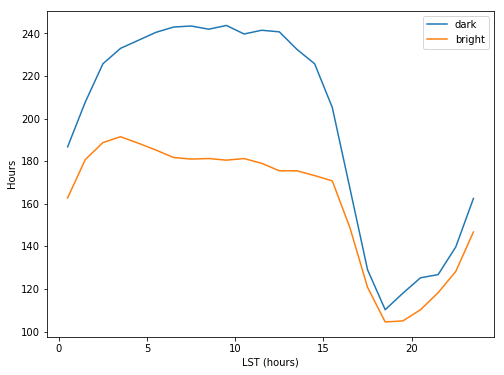

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(24) + 0.5, dark, label='dark')
plt.plot(np.arange(24) + 0.5, bright, label='bright')
plt.xlabel('LST (hours)')
plt.ylabel('Hours')
plt.legend()

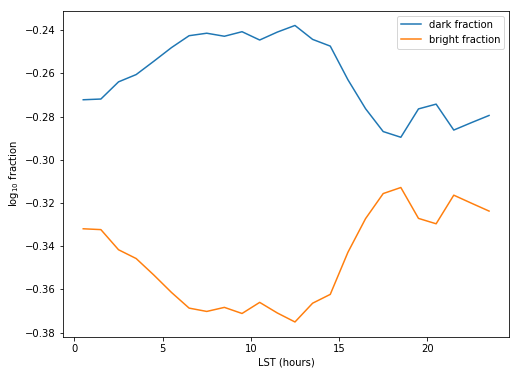

In [21]:
plt.figure(figsize=(8, 6))
all = dark + bright
plt.plot(np.arange(24) + 0.5, np.log10(dark / all), label='dark fraction')
plt.plot(np.arange(24) + 0.5, np.log10(bright / all), label='bright fraction')
plt.xlabel('LST (hours)')
plt.ylabel('log$_{10}$ fraction')
plt.legend()

In [22]:
print(dark.sum() / (dark.sum() + bright.sum()))

0.552583533776


In [23]:
print(dark.sum())
print(bright.sum())

4767.0
3859.75


In [24]:
dark = np.zeros(24)
bright = np.zeros(24)
for (lst, moon_alt, moon_illumination) in zip(lsts, moon_alts, moon_illuminations):
    ilst = np.int32(np.floor(lst / 15.))
    if((moon_illumination < 0.35)):
        dark[ilst] = dark[ilst] + interval_hours 
    else:
        bright[ilst] = bright[ilst] + interval_hours

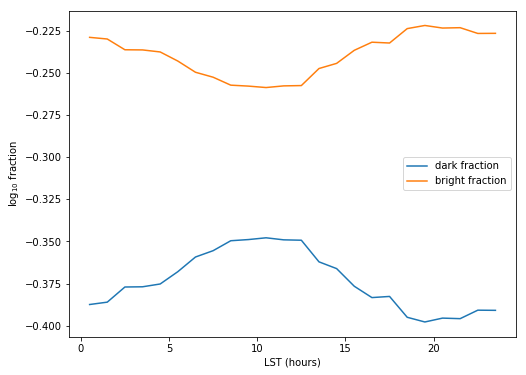

In [25]:
plt.figure(figsize=(8, 6))
all = dark + bright
plt.plot(np.arange(24) + 0.5, np.log10(dark / all), label='dark fraction')
plt.plot(np.arange(24) + 0.5, np.log10(bright / all), label='bright fraction')
plt.xlabel('LST (hours)')
plt.ylabel('log$_{10}$ fraction')
plt.legend()

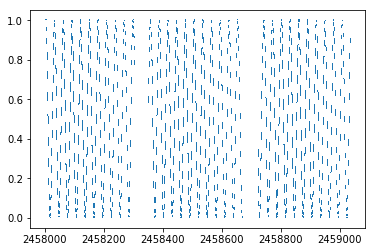

In [26]:
plt.plot(exposures, moon_illuminations, ',')